**Student: Bucă Mihnea-Vicențiu** 

**Msc : Sisteme Distributie**

**Group: 408**

### Lab 1 - Introduction
### Outlier detection vs novelty detection

Outlier detection assumes that training data consists of both normal and anomalous events.  Novelty detection is a semi-supervised approach that only permits normal samples in the training data. Some models from both **scikit-learn** and pyod allow to specify the unwanted setup with the **novelty** parameter.

Some metrics we will use:
* $TPR = \frac{TP}{TP + FN}$ (sensitivity recall)
* $TNR = \frac{TN}{TN + FP}$ (specificity)
* $BA = \frac{TPR + TNR}{2}$ (balanced accuracy)
* $FPR = \frac{FP}{FP + TN}$ 
* $AUC$ (Area under the ROC curve)
* $ROC$ curve is drawn by computing $TPR$ and $FPR$ at every possible threshold 

### Exercises 

Ex. 1

Use the **generate_data()** function from **pyod.utils.data** to generate a 2-dimentional dataset with 500 normal samples (400 training samples and 100 test samples) with a contamination rate of 0.1.
Use **pyplot.scatter** function to plot the training samples, choosing a different color for the outliers.

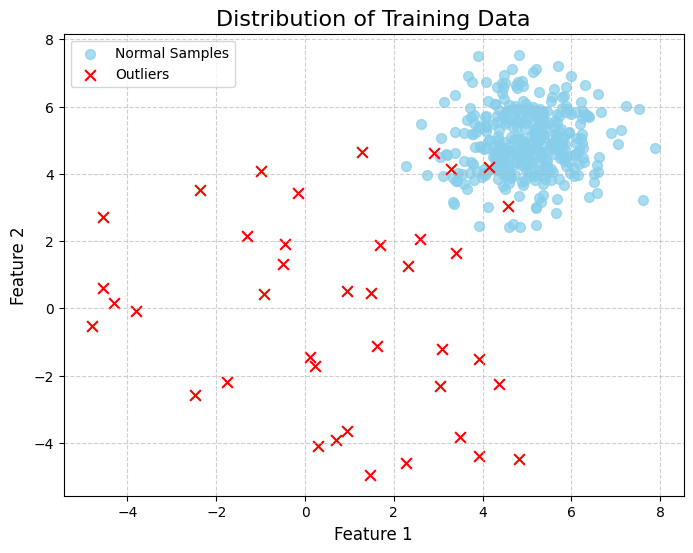

In [ ]:
from pyod.utils.data import generate_data
import matplotlib.pyplot as plt

## -- Data Generation --
X_train, X_test, y_train, y_test = generate_data(
    n_train=400, 
    n_test=100, 
    n_features=2,
    contamination=0.1,
    random_state=30
)

plt.figure(figsize=(8, 6))

is_normal  = (y_train == 0)
is_outlier = (y_train == 1)

plt.scatter(X_train[is_normal, 0], X_train[is_normal, 1],
        c='skyblue',
        s=50,
        alpha=0.7,
        label='Normal Samples')

plt.scatter(X_train[is_outlier, 0], X_train[is_outlier, 1], 
        c='red', 
        s=60,
        marker='x',
        label='Outliers')

plt.title('Distribution of Training Data', fontsize=16)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

Ex.2 

Choose a model from **pyod** (ex: KNN), leave all the parameters default (except the contamination, which will match the contamination used for dataset generation) and fit it with the training data. Get the prediction of the model for both the training and the test data.

Use the **confusion_matrix** function from **sklearn.metrics** to find the number of TN, TP, FN and FP and compute the balanced accuracy.

Use the **roc_curve()** function from **sklearn.metrics** to compute the ROC curve and then plot it with **plot()** function.

Change the contamination rate used by the model and see how the reported
metrics change.

Confusion Matrix:
 TN=90, FP=0, FN=0, TP=10
Balanced Accuracy: 1.000



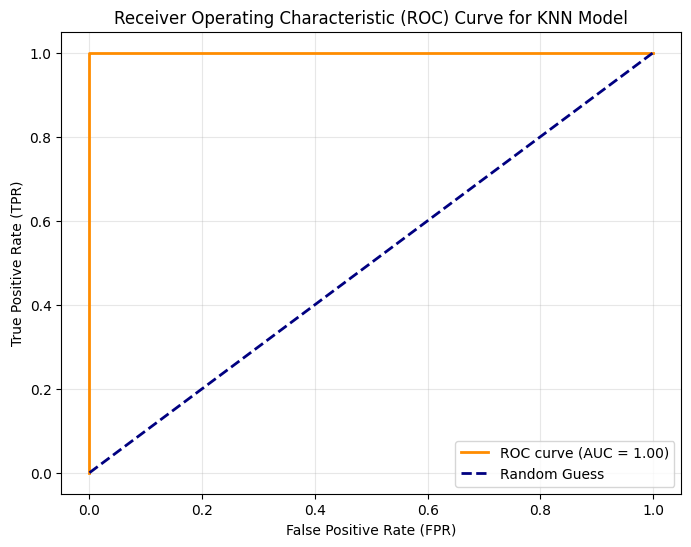

In [15]:
from pyod.models.knn import KNN
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, roc_curve, auc

knn_model = KNN(contamination=0.1)
knn_model.fit(X_train)

y_test_pred = knn_model.predict(X_test)
y_test_scores = knn_model.decision_function(X_test)

cm = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm.ravel()

balanced_acc = balanced_accuracy_score(y_test, y_test_pred)
print(f"Confusion Matrix:\n TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print(f"Balanced Accuracy: {balanced_acc:.3f}\n")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess') 

plt.title('Receiver Operating Characteristic (ROC) Curve for KNN Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

plt.show()

# Change contamination rate and observe metrics
# A low contamination rate (eg. 0.05) means the guard will only stop people who are extremely suspicious.
# A medium contamination rate (eg. 0.1) means the guard has a standard idea of what's suspicious.
# A high contamination rate (eg. 0.2) means the guard is very jumpy and will stop anyone who looks even slightly out of place.

Ex.3

Generate a unidimensional dataset with 10% contamination rate, 1000 training samples and no testing samples using **generate_data()**. Try to detect the anomalies in the dataset by using the Z-scores. In order to do that you should compute the Z-score threshold that would classify the given percent (contamination rate) of data as anomalies (use **np.quantile()** function). Compute the
balanced accuracy of the designed method.

Z-Score Threshold: 1.147
This means any point with an absolute Z-score > 1.147 is flagged as an anomaly.
Balanced Accuracy (Z-score method): 0.878



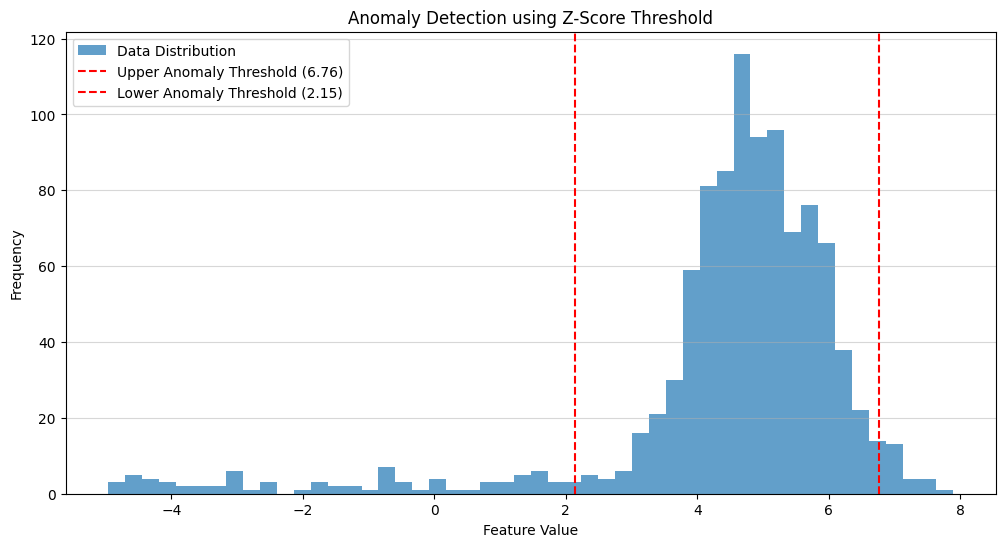

In [17]:
import numpy as np
from sklearn.metrics import balanced_accuracy_score

X_train_uni, _, y_train_uni, _ = generate_data(
    n_train=1000, 
    n_test=0, 
    n_features=1, 
    contamination=0.1,
    random_state=30)

z_scores = (X_train_uni - np.mean(X_train_uni)) / np.std(X_train_uni)

threshold = np.quantile(np.abs(z_scores), 0.9)

y_pred_uni = (np.abs(z_scores) > threshold).astype(int)

balanced_acc_uni = balanced_accuracy_score(y_train_uni, y_pred_uni)

print(f"Z-Score Threshold: {threshold:.3f}")
print(f"This means any point with an absolute Z-score > {threshold:.3f} is flagged as an anomaly.")
print(f"Balanced Accuracy (Z-score method): {balanced_acc_uni:.3f}\n")

plt.figure(figsize=(12, 6))
plt.hist(X_train_uni, bins=50, alpha=0.7, label='Data Distribution')

mean_val = np.mean(X_train_uni)
std_val = np.std(X_train_uni)
lower_bound = mean_val - threshold * std_val
upper_bound = mean_val + threshold * std_val

plt.axvline(upper_bound, color='r', linestyle='--', label=f'Upper Anomaly Threshold ({upper_bound:.2f})')
plt.axvline(lower_bound, color='r', linestyle='--', label=f'Lower Anomaly Threshold ({lower_bound:.2f})')

plt.title('Anomaly Detection using Z-Score Threshold')
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.5)

plt.show()

Ex.4

Same as Ex. 3 but for a multidimensional dataset. Choose your own mean vector $\mu$ and covariance matrix $\Sigma$ and build your dataset by hand starting with the samples generated from a multivariate standard normal distribution, $x ∼ \mathcal{N}(0, I)$. Using the Cholesky decomposition of the covariance matrix $\Sigma = LL^T$ draw your samples $y$ like this: $y = Lx + \mu$ and then compute the Z-scores. All other tasks as in Ex. 3.

Balanced Accuracy (Mahalanobis Distance): 0.933


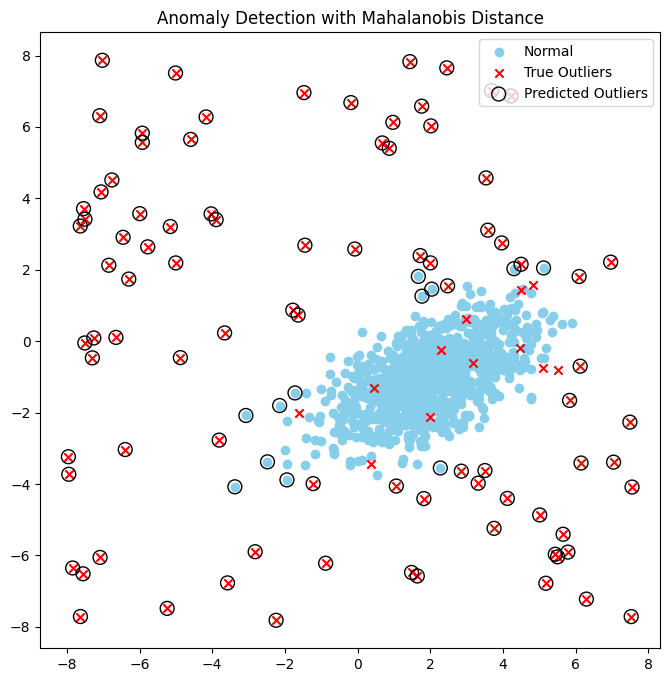

In [ ]:
np.random.seed(123)
n_samples = 1000
contamination = 0.1
n_outliers = int(n_samples * contamination)
n_inliers = n_samples - n_outliers

true_mu = np.array([2, -1])
# this means that the data cloud will be centered at the point (2, -1)

true_Sigma = np.array([[2.0, 0.8], [0.8, 1.0]])
# the data will be more spread out along the x-axis than the y-axis.
# Because this is a positive number, it means there is a positive correlation. 
# As x increases, y tends to increase. This will tilt our data cloud into an ellipse.

# Cholesky decomposition of the covariance matrix
L = np.linalg.cholesky(true_Sigma)

X_inliers = np.random.randn(n_inliers, 2)
Y_inliers = X_inliers @ L.T + true_mu

# Generate outliers (far from the main cluster)
Y_outliers = np.random.uniform(low=-8, high=8, size=(n_outliers, 2))

# Combine inliers and outliers into the final dataset
Y = np.vstack([Y_inliers, Y_outliers])
y_true = np.hstack([np.zeros(n_inliers), np.ones(n_outliers)])

mu_est = np.mean(Y_inliers, axis=0)
Sigma_est = np.cov(Y_inliers.T)
Sigma_inv = np.linalg.inv(Sigma_est)

# Compute Mahalanobis distance
mahal_distances = np.zeros(n_samples)
for i in range(n_samples):
    diff = Y[i] - mu_est
    # This is the formula:(x-μ)ᵀΣ⁻¹(x-μ)
    mahal_distances[i] = np.sqrt(diff.T @ Sigma_inv @ diff)

threshold_mahal = np.quantile(mahal_distances, 1 - contamination)
y_pred_mahal = (mahal_distances > threshold_mahal).astype(int)

balanced_acc_mahal = balanced_accuracy_score(y_true, y_pred_mahal)
print(f"Balanced Accuracy (Mahalanobis Distance): {balanced_acc_mahal:.3f}")

plt.figure(figsize=(8, 8))
plt.scatter(Y[y_true==0, 0], Y[y_true==0, 1], c='skyblue', label='Normal')
plt.scatter(Y[y_true==1, 0], Y[y_true==1, 1], c='red', marker='x', label='True Outliers')
plt.scatter(Y[y_pred_mahal==1, 0], Y[y_pred_mahal==1, 1], 
            edgecolor='k', facecolor='none', s=100, label='Predicted Outliers')

plt.title("Anomaly Detection with Mahalanobis Distance")
plt.legend()
plt.show()